# TV Show Decision Maker (Main Notebook)

This notebook is the main entry point for the project. It demonstrates:
- Loading the Kaggle TMDB TV dataset (local CSV) using **pandas**
- Basic data cleaning / feature extraction
- Creating `TVShow` objects and using `ShowRecommender` (composition)
- Basic plots using **matplotlib**
- An optional interactive menu loop (`while`) for exploring recommendations

Note: The dataset CSV is not committed to git because it is large. You must provide a local path.


## 1) Imports

In [1]:
import os
import sys 
from pathlib import Path

#set a working directory to the project root folder (TV Decision Maker)
os.chdir(r"C:\TV Show Decision Maker") 

#added these to find src
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.tv_show import TVShow
from src.show_recommender import ShowRecommender

## 2) Configure dataset path

Set `CSV_PATH` to wherever you stored `TMDB_tv_dataset_v3.csv`.

Example (Windows):
- `r"C:\\Users\\91940\\Downloads\\archive\\TMDB_tv_dataset_v3.csv"`

In [2]:
#Update this to your local file path.
#CSV_PATH = r"C:\\Users\\91940\\Downloads\\archive\\TMDB_tv_dataset_v3.csv"
CSV_PATH = r"C:\TV Show Decision Maker\data\TMDB_tv_dataset_v3.csv"

csv_file = Path(CSV_PATH)
if not csv_file.exists():
    raise FileNotFoundError(f"CSV not found at: {csv_file}")

try:
    with open(csv_file, 'r', encoding='utf-8') as f:
        print(f"First line: {f.readline()[:100]}")  # confirm file can be opened
except PermissionError:
    raise PermissionError(f"Cannot read CSV file at {csv_file}. Check Windows file permissions.")  

print(csv_file)

First line: "id","name","number_of_seasons","number_of_episodes","original_language","vote_count","vote_average"
C:\TV Show Decision Maker\data\TMDB_tv_dataset_v3.csv


## 3) Load dataset with pandas (advanced library #1)

We load only the columns we need to build `TVShow` objects.

In [3]:
import pandas as pd
import ast

csv_file = CSV_PATH

usecols = [
    "name",
    "genres",
    "number_of_episodes",
    "original_language",
    "vote_average",
    "first_air_date",
]

# Limit rows for fast demos; set to None to load everything (slow on a 70MB file).
ROW_LIMIT = 1000

#read csv
df = pd.read_csv(csv_file, sep=',', usecols=usecols, nrows=ROW_LIMIT)

def parse_genres(genres_str):
    """
    Parse TMDB genre strings like:
    "[{'id': 18, 'name': 'Drama'}]"
    """
    if pd.isna(genres_str) or genres_str.strip() == "":
        return []
    return [g.strip() for g in genres_str.split(",") if g.strip()]

df["genres"] = df["genres"].apply(parse_genres)

df.head()

,name,number_of_episodes,original_language,vote_average,first_air_date,genres
0,Game of Thrones,73,en,8.442,2011-04-17,"[Sci-Fi & Fantasy, Drama, Action & Adventure]"
1,Money Heist,41,es,8.257,2017-05-02,"[Crime, Drama]"
2,Stranger Things,34,en,8.624,2016-07-15,"[Drama, Sci-Fi & Fantasy, Mystery]"
3,The Walking Dead,177,en,8.121,2010-10-31,"[Action & Adventure, Drama, Sci-Fi & Fantasy]"
4,Lucifer,93,en,8.486,2016-01-25,"[Crime, Sci-Fi & Fantasy]"


## 4) Clean / transform columns

- Extract `year` from `first_air_date`
- Convert numeric columns
- Split genres into lists

In [4]:
#Extract year as an integer (YYYY) from date strings like "2011-04-17".
df["year"] = pd.to_datetime(df["first_air_date"], errors="coerce").dt.year

#convert these to numeric types
df["number_of_episodes"] = pd.to_numeric(df["number_of_episodes"], errors="coerce")
df["vote_average"] = pd.to_numeric(df["vote_average"], errors="coerce")

#drop rows where number_of_episodes and vote_average are missing
df = df.dropna(subset=["number_of_episodes", "vote_average"]).copy()

#convert numeric columns to appropriate type
df["number_of_episodes"] = df["number_of_episodes"].astype(int)
df["vote_average"] = df["vote_average"].astype(float)

#fill missing names and languages with empty strings
df["name"] = df["name"].fillna("").str.strip()
df["original_language"] = df["original_language"].fillna("").str.strip()

# Ensure genres always a list
df["genres"] = df["genres"].apply(lambda g: g if isinstance(g, list) else [])

## 5) Build `TVShow` objects + `ShowRecommender`

This section demonstrates:
- A `for` loop
- Exception handling when creating objects
- Composition: `ShowRecommender` stores many `TVShow` objects

In [5]:
recommender = ShowRecommender()

tv_shows = []
skipped = 0

#iterate through each row of dataframe
for _, row in df.iterrows():
    try:
        #extract genres, if list is empty, use "Unknown"
        #convert all genre names to lowercase for consistency
        genres = row["genres"] if row["genres"] else ["Unknown"]
        genres = [g.lower() for g in genres]
        
        #make TVShow object from row
        show = TVShow(
            title=row["name"],
            genre=genres,
            num_episodes=row["number_of_episodes"],
            avg_rating=row["vote_average"],
            language=row["original_language"],
            year=None if pd.isna(row["year"]) else int(row["year"]),
        )
        #add valid TVShow object to list
        tv_shows.append(show)

    except Exception:
        #increment skipped counter if there are any errors making the TVShow
        skipped += 1
#add all of the loaded shows to the recommender
recommender.add_shows_from_list(tv_shows)
#print summary stats
print(f"Loaded shows: {recommender.get_total_shows()} | Skipped: {skipped}")
#call method to display detailed stats about loaded shows
recommender.get_statistic()

Loaded shows: 1000 | Skipped: 0


{'total_shows': 1000,
 'avg_rating': 7.9,
 'total_episodes': 87365,
 'total_genres': 19}

## 6) Quick exploration + plots (advanced library #2)

We use matplotlib to visualize rating distribution and top genres.

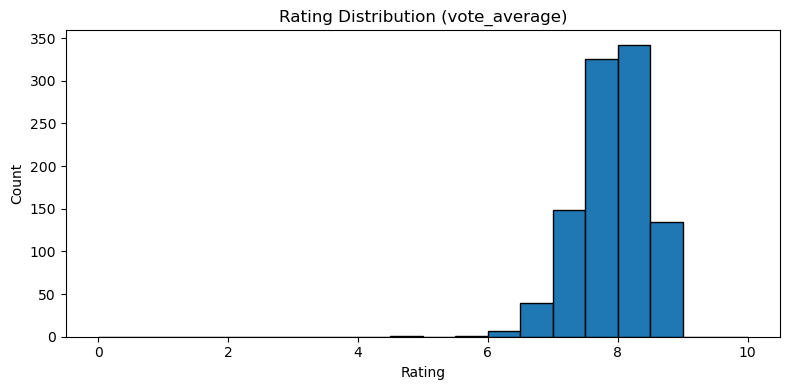

In [6]:
# Ratings histogram
ratings = np.array([s.avg_rating for s in tv_shows], dtype=float)

plt.figure(figsize=(8, 4))
plt.hist(ratings, bins=np.arange(0, 10.5, 0.5), edgecolor="black")
plt.title("Rating Distribution (vote_average)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

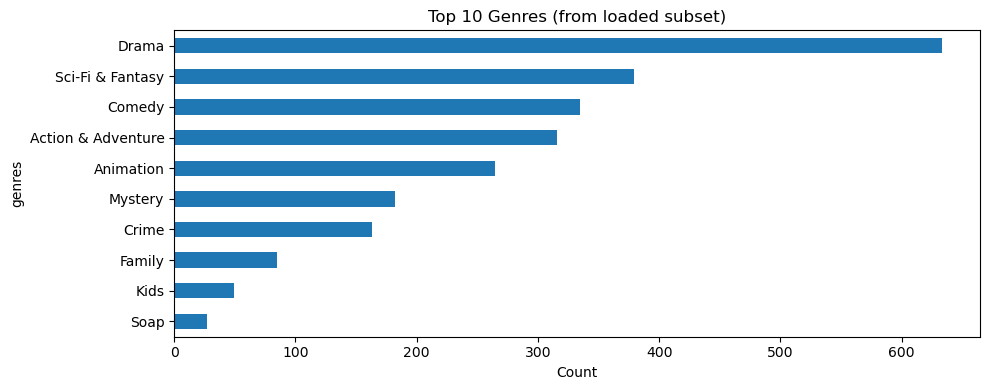

In [7]:
# Top genres bar chart (genres are lists)
# Remove empty genre lists BEFORE exploding
genres_series = df["genres"].apply(lambda g: g if isinstance(g, list) and len(g) > 0 else np.nan)

genre_counts = (
    df["genres"]
    .explode()
    .value_counts()
    .head(10)
)

if genre_counts.empty:
    print("No genre data available to plot.")
else:
    plt.figure(figsize=(10, 4))
    genre_counts.sort_values().plot(kind="barh")
    plt.title("Top 10 Genres (from loaded subset)")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

## 7) Optional interactive menu (`while` loop)

To avoid hanging automated grading, this is disabled by default.

Set `RUN_INTERACTIVE = True` if you want to use it.

In [8]:
RUN_INTERACTIVE = True

if RUN_INTERACTIVE:
    while True:
        print("\nMenu:")
        print("  1) Filter by genre")
        print("  2) Filter by minimum rating")
        print("  3) Search by title")
        print("  4) Get recommendations (top N by rating)")
        print("  5) Quit")

        choice = input("Enter choice: ").strip()

        if choice == "1":
            genre = input("Genre: ").strip()
            matches = recommender.filter_by_genre(genre)
            print(f"Found {len(matches)} shows")
            for s in matches[:10]:
                print(f"- {s.title} ({s.avg_rating}/10)")

        elif choice == "2":
            min_rating = float(input("Minimum rating (0-10): ").strip())
            matches = recommender.filter_by_rating(min_rating)
            print(f"Found {len(matches)} shows")
            for s in matches[:10]:
                print(f"- {s.title} ({s.avg_rating}/10)")

        elif choice == "3":
            query = input("Search term: ").strip()
            matches = recommender.search_by_title(query)
            print(f"Found {len(matches)} shows")
            for s in matches[:10]:
                print(f"- {s.title} ({s.avg_rating}/10)")
                print(s)

        elif choice == "4":
            limit = int(input("How many recommendations? ").strip())
            recs = recommender.get_recommendations(limit=limit)
            for i, s in enumerate(recs, 1):
                print(f"{i}. {s.title} ({s.avg_rating}/10)")

        elif choice == "5":
            print("Goodbye!")
            break

        else:
            print("Invalid choice, try again.")


Menu:
  1) Filter by genre
  2) Filter by minimum rating
  3) Search by title
  4) Get recommendations (top N by rating)
  5) Quit
Enter choice: 1
Genre: Drama
Found 633 shows
- Game of Thrones (8.442/10)
- Money Heist (8.257/10)
- Stranger Things (8.624/10)
- The Walking Dead (8.121/10)
- Riverdale (8.479/10)
- Squid Game (7.831/10)
- Breaking Bad (8.89/10)
- The Good Doctor (8.503/10)
- WandaVision (8.3/10)
- The Flash (7.797/10)

Menu:
  1) Filter by genre
  2) Filter by minimum rating
  3) Search by title
  4) Get recommendations (top N by rating)
  5) Quit
Enter choice: 5
Goodbye!
